In [1]:
!ls

 08-MovieLens-consecutive-ratings.ipynb
 10-surprise-kfold-prec-recal-svd-movielens.ipynb
 12a-TOP-K_off-policy_ReinforceRNN_agent.ipynb
 12-TOP-K_off-policy_IS_example_env.ipynb
 13-MovieLensEnv.ipynb
 14-GenRecEnv.ipynb
 15-JDSimulatedEnv.ipynb
 16_DQN.ipynb
'17_Online User-Agent Interaction Environment Simulator.ipynb'
 agents
'Experiment_Runner&Visualisation.ipynb'
'Experiment_Runner&Visualisation.py'
 logs
 ml100k-offline_2.npz
 ml100k-online_2.npz
 ml100k-online.npz
 MovieLens.ipynb
 MovieLens-Offline_Eval.ipynb
 MovieLens-Online_Eval.ipynb
 None
 README.md
 rec_gym
 results_1m.npz
 results.npz
 Test_GEN_REC_ENV.ipynb
 Test_stable_baselines.ipynb
 Vis_results.ipynb


In [2]:
import cloudpickle

In [4]:
with open('results.npz', 'rb') as f:
    results = cloudpickle.load(f)

In [5]:
results.keys()

dict_keys(['Popularity', 'SVD', 'LinUCB', 'HLinUCB', 'DDPG', 'PPO2'])

In [9]:
import matplotlib.pylab as plt
from pandas import DataFrame
import numpy as np 
from collections import defaultdict

moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values


def precision_at_k(recs, gt, k):
    relevant_items = set(gt[:k])
    
    rec_rel = [item in relevant_items for item in recs[:k]]
    return np.mean(rec_rel)
    
    
def precision_at_k_thresh(rewards, k, threshold=0.):
    rec_rel = [r > threshold for r in rewards[:k]]
    return np.mean(rec_rel)

def dcg_at_k(rewards, k):
    dcg = 0
    for i, r in enumerate(rewards[:k]):
        if i == 0:
            dcg += r
        else:
            dcg += 2**r - 1 / np.log2(i+1)
    return dcg

def ndcg_at_k(rewards, k):
    maxdcg = dcg_at_k(np.sort(rewards)[::-1], k)
    if maxdcg == 0: return 0
    return dcg_at_k(rewards, k) / maxdcg

def visualize(results):
    train_steps = 80000
    
    for K in [5, 10]:
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
        fig.suptitle('@%d' % K)
        
        
        for name, interactions in results.items():
            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[train_steps:]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            precisions = []
            precisions_thresh = []
            ndcgs = []

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number]
                    gt = session_gt_by_user[k][session_number]
                    rew = session_rewards_by_user[k][session_number]

                    p_at_k = precision_at_k(recs, gt, K)
                    precisions.append(p_at_k)

                    precisions_thresh.append(precision_at_k_thresh(rew, K, 0.25))

                    ndcgs.append(ndcg_at_k(np.array(rew)>0.25, K))
            #         ndcgs.append(ndcg_at_k(np.clip(rew, 0, 1), K))
            
                    

            span = 40
            ax[0].plot(moving_average(ndcgs, span=span), 
                       label="%s : NDCG@%d = %.4f" % (name, K, np.mean(ndcgs)))
            ax[0].legend()

            ax[1].plot(moving_average(precisions, span=span), 
                       label="%s : Precision = %.4f" % (name, np.mean(precisions)) )
            ax[1].legend()

            ax[2].plot(moving_average(precisions_thresh, span=span), 
                       label='%s : Precision@%d = %.4f' % (name, K, np.mean(precisions_thresh)) )
            ax[2].legend()
    
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        fig.suptitle('Coverage')
        xs = []
        coverages = []
        for name, interactions in results.items():
            # train
            train_items = set()

            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[:train_steps]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number]

                    for item in recs:
                        train_items.add(item)

            # test
            test_items = set()

            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[:train_steps]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number][:K]

                    for item in recs:
                        test_items.add(item)


            coverage = len(test_items & train_items) / len(train_items)

            xs.append(name)
            coverages.append(coverage)

        ax.bar(xs, coverages)

import recmetrics
def personalization(results):
    train_steps = 80000
    K = 10
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.suptitle('Personalization')
    xs = []
    personalizations = []
    sessioned_recs_at_k = []
    for name, interactions in results.items():
        # test
        test_items = set()

        session_recs_by_user = defaultdict(lambda : defaultdict(list))
        session_gt_by_user = defaultdict(lambda : defaultdict(list))
        session_rewards_by_user = defaultdict(lambda : defaultdict(list))

        prev_user = None

        for i in interactions[:train_steps]:
            u = i.uid 
            recs = i.recs
            gt = i.raw_info['ground_truth_items']
            rewards = i.rewards

            if prev_user is None or u != prev_user:
                prev_user = u
                user_session = len(session_recs_by_user[prev_user])

            session_recs_by_user[prev_user][user_session].extend(recs)
            session_gt_by_user[prev_user][user_session].extend(gt)
            session_rewards_by_user[prev_user][user_session].extend(rewards)

        for k, v in session_recs_by_user.items():
            recs = session_recs_by_user[k][0][:K]
            sessioned_recs_at_k.append(recs)



        personalization = recmetrics.personalization(sessioned_recs_at_k)

        xs.append(name)
        personalizations.append(personalization)

        ax.bar(xs, personalizations)

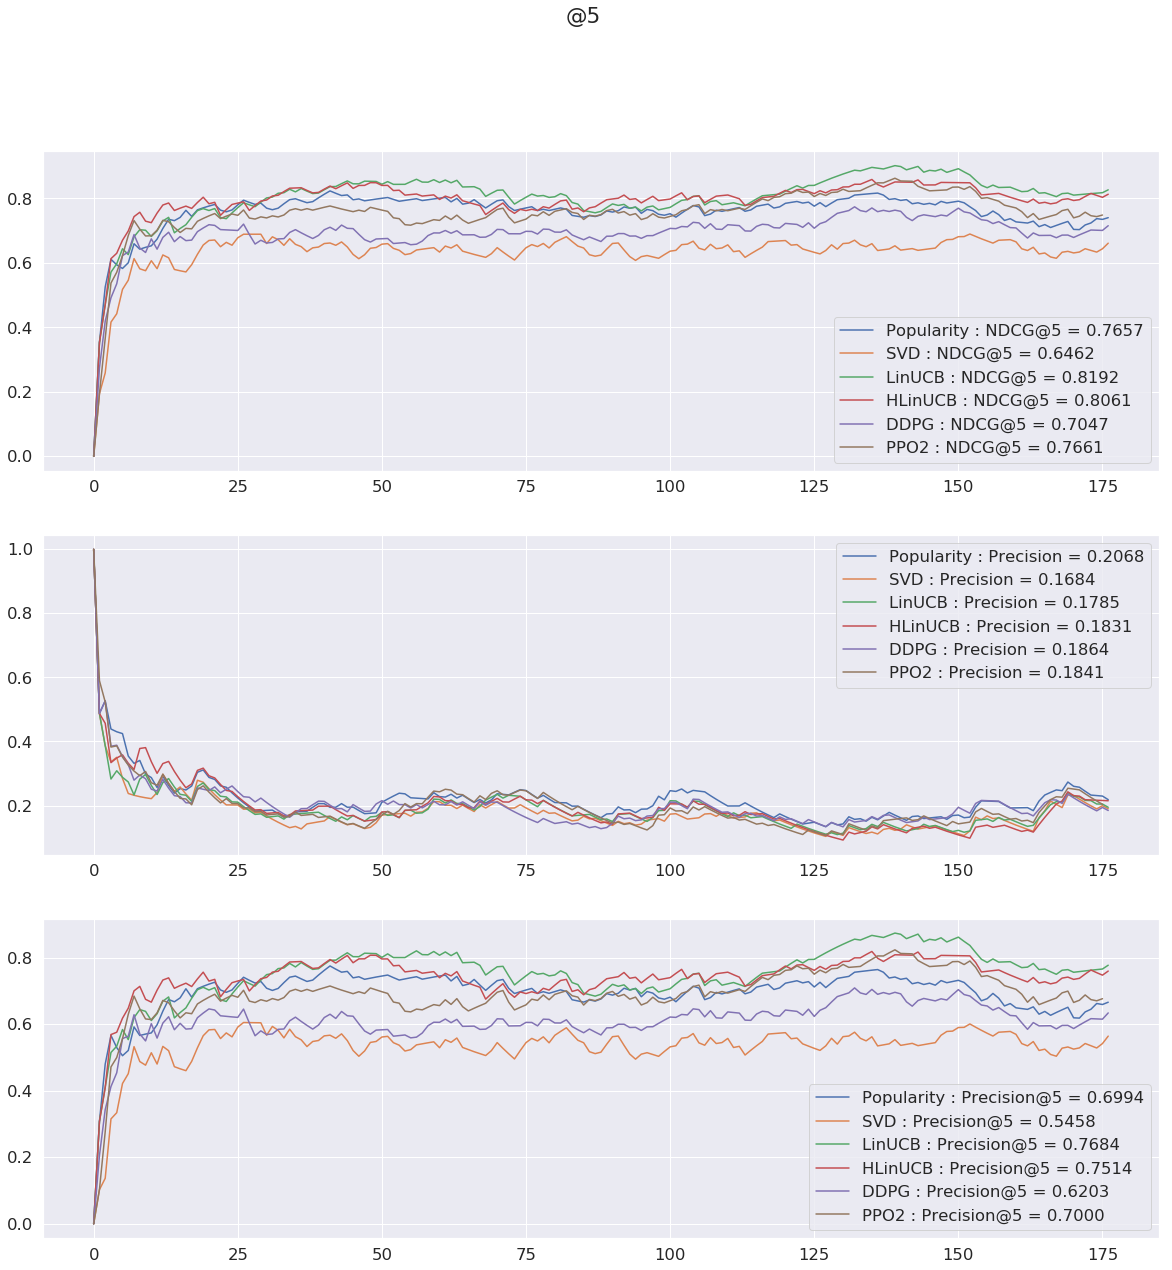

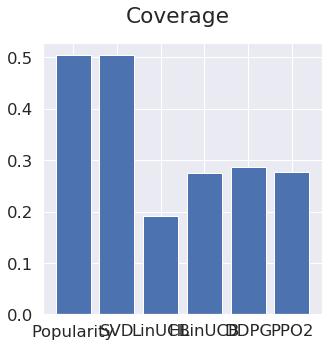

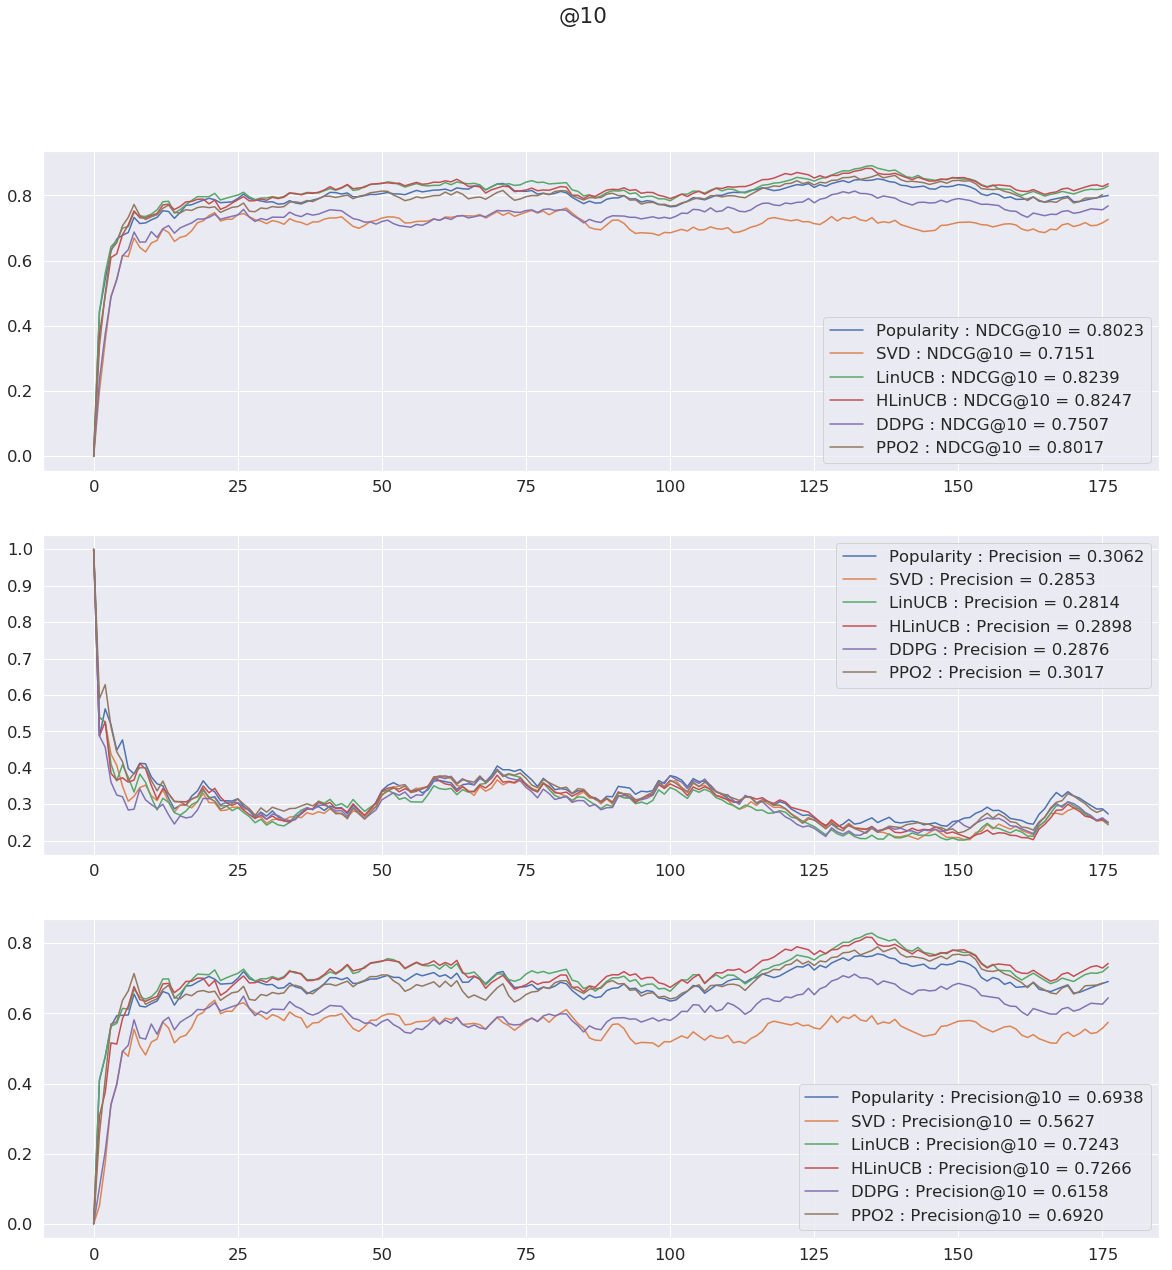

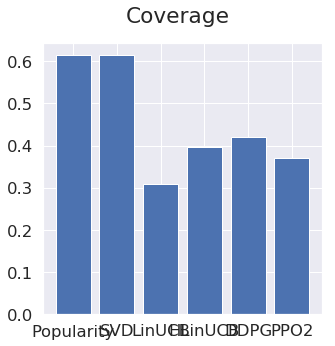

In [30]:
visualize(results)

In [11]:
counts = defaultdict(lambda: defaultdict(int))

for name, interactions in results.items():
    session_recs_by_user = defaultdict(lambda : defaultdict(list))
    session_gt_by_user = defaultdict(lambda : defaultdict(list))
    session_rewards_by_user = defaultdict(lambda : defaultdict(list))

    prev_user = None

    for i in interactions[80000:]:
        u = i.uid 
        recs = i.recs
        gt = i.raw_info['ground_truth_items']
        rewards = i.rewards

        if prev_user is None or u != prev_user:
            prev_user = u
            user_session = len(session_recs_by_user[prev_user])

        session_recs_by_user[prev_user][user_session].extend(recs)
        session_gt_by_user[prev_user][user_session].extend(gt)
        session_rewards_by_user[prev_user][user_session].extend(rewards)

    precisions = []
    precisions_thresh = []
    ndcgs = []

    for k, v in session_recs_by_user.items():
        for session_number in v:

            recs = session_recs_by_user[k][session_number][:10]

            for item in recs:
                counts[name][item] += 1
        

In [28]:
import seaborn as sns
sns.set()
sns.set(font_scale=1.5) 

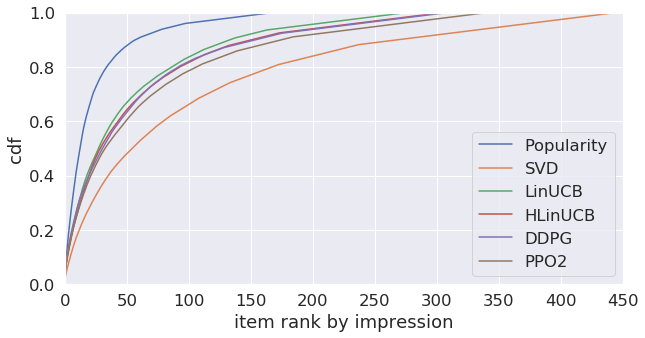

In [29]:
plt.figure(figsize=(10, 5))
for name, c in counts.items():
    plt.plot(np.cumsum(np.sort(list(c.values()))[::-1])/np.sum(list(c.values())), label=name)

plt.ylabel('cdf')
plt.xlabel('item rank by impression')
plt.xlim(0, 450)
plt.ylim(0, 1)
plt.legend()
plt.show();